In [22]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Example audio file
audio_file = "../raw_data/ma2_FV2_MP3.mp3"
#audio_file = "../website/temp_audio.wav"

# Load audio data 
audio, sr = librosa.load(audio_file, sr=None)

# Play sound 
import IPython.display as ipd  
ipd.Audio(audio_file)


In [3]:
def get_mp3_info(y,sr):

    # Get sampling rate
    sampling_rate = sr

    # Get frames
    total_samples = len(y)

    # Get duration
    duration = librosa.get_duration(y=y, sr=sr)

    return {
        "Sampling Rate (Hz)": sampling_rate,
        "Frames": total_samples,
        "Duration (seconds)": duration
    }

info = get_mp3_info(audio,sr)
print("MP3 File Information:")
for key, value in info.items():
    print(f"{key}: {value}")

MP3 File Information:
Sampling Rate (Hz): 44100
Frames: 27695
Duration (seconds): 0.6280045351473923


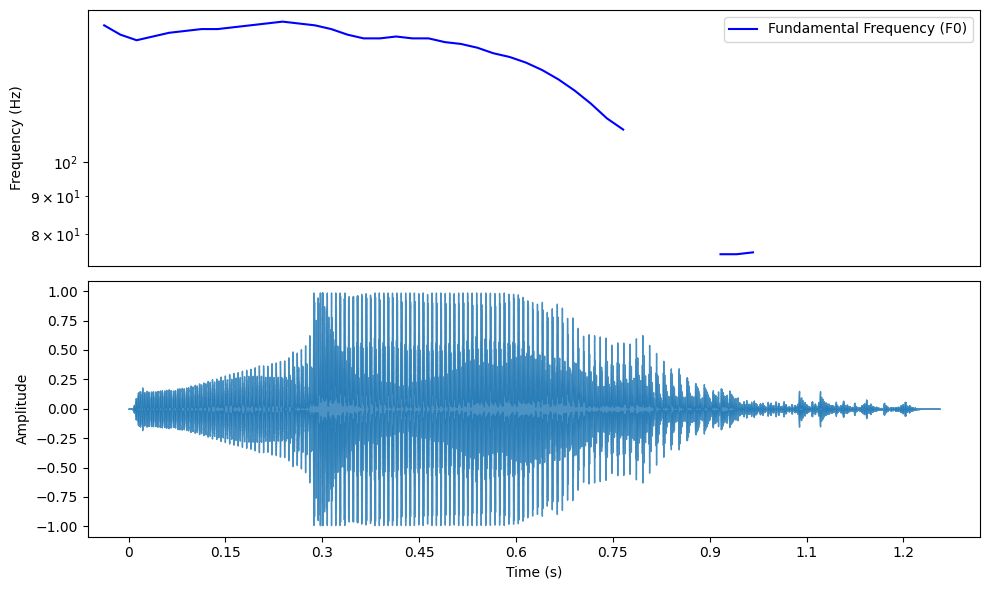

In [4]:
#audio = librosa.to_mono(audio)
#audio = librosa.util.fix_length(audio, size=sr) # 1 second of audio
#audio = librosa.util.normalize(audio)

# Calculate pitch using fundamental frequency (f0)
f0, voiced_flag, voiced_probs = librosa.pyin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

# Plot pitch
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.semilogy(f0, label='Fundamental Frequency (F0)', color='b')
plt.ylabel('Frequency (Hz)')
plt.xticks([])
plt.xlim([0, len(f0)])
plt.legend(loc='upper right')

# Display waveform
plt.subplot(2, 1, 2)
librosa.display.waveshow(audio, alpha=0.8)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

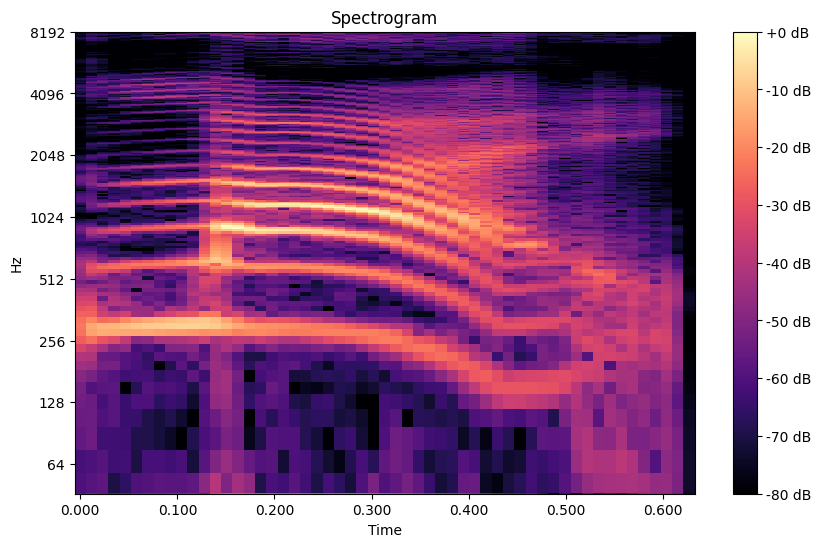

In [5]:
def get_spectrum(audio):

    # Compute STFT
    D = librosa.stft(audio)

    # Compute magnitude
    magnitude = np.abs(D)

    # Convert to dB
    log_magnitude = librosa.amplitude_to_db(magnitude, ref=np.max)

    # Plot spectrum
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(log_magnitude, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.ylim([32, 8192])
    plt.show()

def save_spectrum(audio, output_file=None):

    # Compute STFT
    D = librosa.stft(audio)

    # Compute magnitude
    magnitude = np.abs(D)

    # Convert to dB
    log_magnitude = librosa.amplitude_to_db(magnitude, ref=np.max)

    # Plot spectrum
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(log_magnitude, sr=sr, x_axis='time', y_axis='log')
    plt.axis('off')
    #plt.ylim([32, 8192])

    if output_file: plt.savefig(output_file, bbox_inches='tight', pad_inches=0, transparent=True)
    else: plt.show()    

    plt.close()

get_spectrum(audio=audio)
save_spectrum(audio=audio,output_file="spectrum.png")

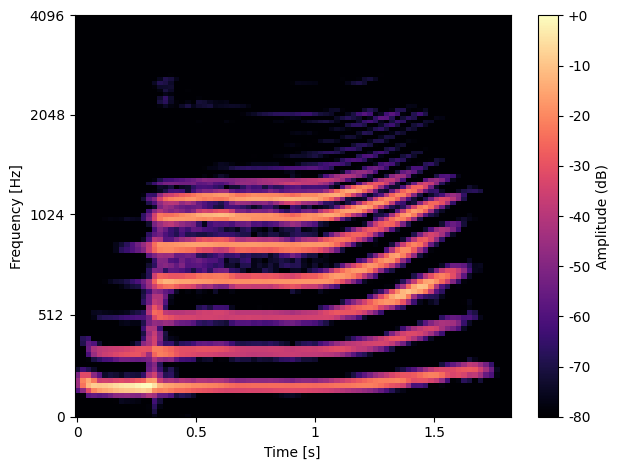

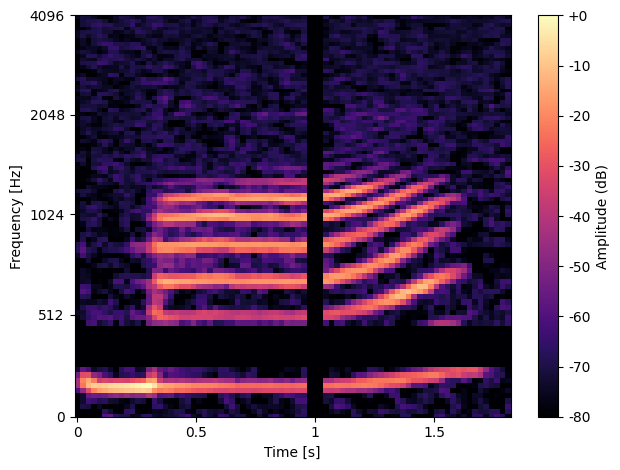

In [32]:
from scipy.signal import butter, sosfilt

def time_stretch(audio, rate=1.25):
    return librosa.effects.time_stretch(y=audio, rate=rate)

def pitch_shift(audio, sr, n_steps=2):
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=n_steps)

def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio
    
def time_shift(audio, shift_max=0.2, shift_direction='both', roll=False):
    shift = int(len(audio) * shift_max * np.random.rand())
    print(f"Shift amount: {shift}")
    
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        shift = -shift if np.random.rand() > 0.5 else shift
    
    if roll:
        # Roll the audio
        return np.roll(audio, shift)
    else:
        # Shift and set out-of-bounds to zero
        shifted_audio = np.zeros_like(audio)
        if shift > 0:
            # Shift to the right
            shifted_audio[shift:] = audio[:-shift]
        else:
            # Shift to the left
            shift = -shift
            shifted_audio[:-shift] = audio[shift:]
        return shifted_audio

def apply_filter(audio, sr, low_freq=32, high_freq=4096):
    # Design a bandpass filter
    sos = butter(10, [low_freq, high_freq], btype='bandpass', fs=sr, output='sos')
    # Apply the filter
    filtered_audio = sosfilt(sos, audio)
    return filtered_audio

def dynamic_range_compression(audio):
    return librosa.effects.preemphasis(y=audio)

def change_volume(audio, gain=1.5):
    return audio * gain

def spec_augment(mel_spectrogram, freq_mask_param=10, time_mask_param=10):
    mel_spectrogram = mel_spectrogram.copy()
    num_mel_channels = mel_spectrogram.shape[0]

    # Frequency masking
    f = np.random.uniform(low=0.0, high=freq_mask_param)
    f0 = int(np.random.uniform(low=0.0, high=num_mel_channels - f))
    mel_spectrogram[f0:f0 + int(f), :] = 0

    # Time masking
    t = np.random.uniform(low=0.0, high=time_mask_param)
    t0 = int(np.random.uniform(low=0.0, high=mel_spectrogram.shape[1] - t))
    mel_spectrogram[:, t0:t0 + int(t)] = 0

    return mel_spectrogram

def augment_audio(audio, sr):
    audio = time_stretch(audio=audio, rate=np.random.uniform(0.8, 1.2))
    audio = pitch_shift(audio, sr, n_steps=np.random.randint(-5, 5))
    audio = add_noise(audio, noise_factor=np.random.uniform(0.001, 0.01))
    audio = time_shift(audio, shift_max=0.2, shift_direction='both')
    audio = dynamic_range_compression(audio)
    return audio

def augment_mel_spectrogram(mel_spectrogram, freq_mask_param=10, time_mask_param=10):
    mel_spectrogram = spec_augment(mel_spectrogram, freq_mask_param, time_mask_param)
    return mel_spectrogram

def pad_or_truncate(audio, target_length):
    if len(audio) > target_length:
        return audio[:target_length]
    elif len(audio) < target_length:
        return np.pad(audio, (0, target_length - len(audio)), 'constant')
    else:
        return audio

audio2 = audio
#audio2 = time_stretch(audio=audio2, rate=0.5)
#audio2 = pitch_shift(audio2, sr, -6)
audio2 = add_noise(audio2, noise_factor=0.15)
#audio2 = time_shift(audio2, shift_max=0.2, shift_direction='both')
#audio2 = change_volume(audio,100)
#audio2 = dynamic_range_compression(audio)

# Trim silence
#print(librosa.get_duration(y=audio,sr=sr))
#audio, _ = librosa.effects.trim(audio)
#print(librosa.get_duration(y=audio,sr=sr))

# Normalize audio
#audio = librosa.util.normalize(audio)

#audio = apply_filter(audio, sr)

#audio = pad_or_truncate(audio, sr*2)

m = librosa.feature.melspectrogram(y=audio,sr=sr, n_mels=128, n_fft=2048, hop_length=512)
m_db = librosa.amplitude_to_db(m, ref=np.max)
img = librosa.display.specshow(m_db, x_axis='time',y_axis='mel')

cbar = plt.colorbar(img, format='%+2.0f')
cbar.set_label('Amplitude (dB)')

#plt.title('Mel spectrogram')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.ylim([0, 4096])

plt.tight_layout()
plt.show()


##
m = librosa.feature.melspectrogram(y=audio2,sr=sr, n_mels=128, n_fft=2048, hop_length=512)

m = augment_mel_spectrogram(m,freq_mask_param=100, time_mask_param=10)

m_db = librosa.amplitude_to_db(m, ref=np.max)
img = librosa.display.specshow(m_db, x_axis='time',y_axis='mel')

cbar = plt.colorbar(img, format='%+2.0f')
cbar.set_label('Amplitude (dB)')

#plt.title('Mel spectrogram')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.ylim([0, 4096])

plt.tight_layout()
plt.show()


## Prepare data 

In [20]:
import os
import csv
import re

# Create a list to store the extracted data
data = []

# Loop through the files in the directory
directory = '../raw_data/'
maxFiles = -1

for filename in os.listdir(directory):
    if filename.endswith('.mp3'):

        # Extract info from filename
        match = re.match(r'(\w+)(\d+)_(\w+)_MP3\.mp3', filename)
        if match:
            sound, tone, speaker = match.groups()

            audio, sr = librosa.load(directory+filename, sr=None)
            info = get_mp3_info(audio,sr)

            img_filename = f"spectrum_data/{sound}{tone}_{speaker}.png"
            save_spectrum(audio=audio,output_file=img_filename)
            
            data.append([filename, img_filename, sound, tone, speaker, info["Duration (seconds)"], info["Frames"], info["Sampling Rate (Hz)"] ])
        else:
            print(f"Error: No match found for filename '{filename}'")

        if maxFiles != -1 and len(data) >= maxFiles:
            break

# Write data to CSV
csv_file = 'output.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['filename', 'img_filename', 'sound', 'tone', 'speaker', 'Duration (seconds)','Frames','Sampling Rate (Hz)'])
    writer.writerows(data)

print(f'CSV file "{csv_file}" has been created')


NameError: name 'get_mp3_info' is not defined

In [76]:
import pandas as pd
import seaborn as sns

train = pd.read_csv("output.csv")
num_entries = train.shape[0]
print(f'Number of entries in output.csv: {num_entries}')

Number of entries in output.csv: 9503


In [77]:
# Check csv file 
train.sample(10)
#train.head(10)

,filename,img_filename,sound,tone,speaker,Duration (seconds),Frames,Sampling Rate (Hz)
7562,jia3_FV2_MP3.mp3,spectrum_data/jia3_FV2.png,jia,3,FV2,0.915351,40367,44100
29,rua3_MV2_MP3.mp3,spectrum_data/rua3_MV2.png,rua,3,MV2,0.967596,42671,44100
5474,peng4_MV2_MP3.mp3,spectrum_data/peng4_MV2.png,peng,4,MV2,0.471270,20783,44100
5629,ta4_FV3_MP3.mp3,spectrum_data/ta4_FV3.png,ta,4,FV3,0.680249,29999,44100
5023,zang3_MV1_MP3.mp3,spectrum_data/zang3_MV1.png,zang,3,MV1,0.575760,25391,44100
6992,ruo3_FV3_MP3.mp3,spectrum_data/ruo3_FV3.png,ruo,3,FV3,0.993719,43823,44100
8280,shua3_FV2_MP3.mp3,spectrum_data/shua3_FV2.png,shua,3,FV2,1.072086,47279,44100
3639,teng1_MV1_MP3.mp3,spectrum_data/teng1_MV1.png,teng,1,MV1,0.497392,21935,44100
9477,zu4_MV1_MP3.mp3,spectrum_data/zu4_MV1.png,zu,4,MV1,0.419025,18479,44100
1093,qia3_MV2_MP3.mp3,spectrum_data/qia3_MV2.png,qia,3,MV2,0.993719,43823,44100


/var/folders/sy/mg_z9v4x0ms652tc0sx_gq6h0000gn/T/ipykernel_78494/3996599771.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=speaker_counts, x='tone', y='speaker', palette="viridis")


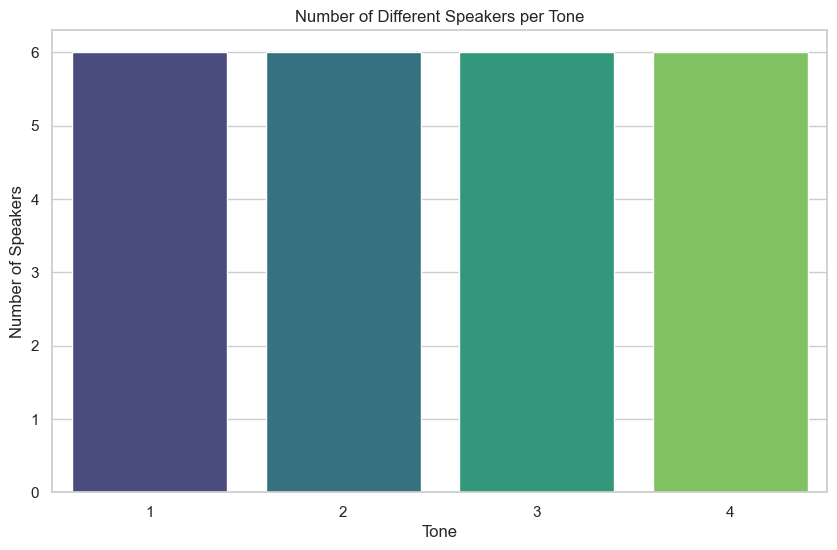

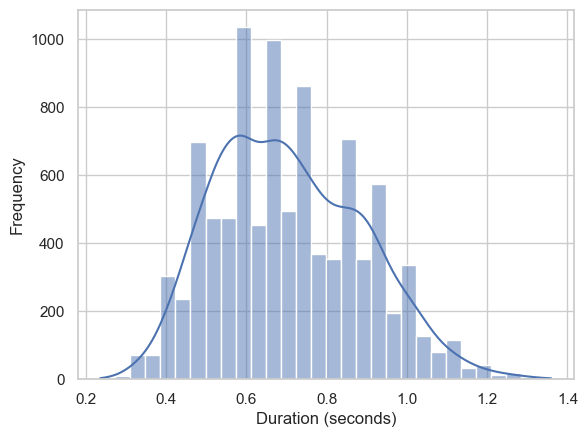

In [79]:
# Control plots
speaker_counts = train.groupby('tone')['speaker'].nunique().reset_index()
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(data=speaker_counts, x='tone', y='speaker', palette="viridis")
plt.title("Number of Different Speakers per Tone")
plt.xlabel("Tone")
plt.ylabel("Number of Speakers")
plt.show()

sns.histplot(train['Duration (seconds)'], bins=30, kde=True)
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

## ML 

In [274]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Extract file paths and tone labels
data = pd.read_csv('output.csv')
file_paths = data['img_filename']
tones = data['tone']

# Encode tone labels
label_encoder = LabelEncoder()
tones_encoded = label_encoder.fit_transform(tones)
num_classes = len(label_encoder.classes_)

print("File paths:")
print(file_paths)

print("\nTones encoded:")
print(tones_encoded)

print("\nNumber of classes:")
print(num_classes)

File paths:
0          spectrum_data/sa3_MV1.png
1         spectrum_data/cao2_FV1.png
2        spectrum_data/hong1_MV2.png
3       spectrum_data/zheng3_MV3.png
4        spectrum_data/shao4_MV1.png
                    ...             
9498     spectrum_data/zhan3_MV3.png
9499     spectrum_data/zhei3_FV2.png
9500     spectrum_data/peng4_FV1.png
9501    spectrum_data/chuan1_FV2.png
9502      spectrum_data/luo4_MV3.png
Name: img_filename, Length: 9503, dtype: object

Tones encoded:
[2 1 0 ... 3 0 3]

Number of classes:
4


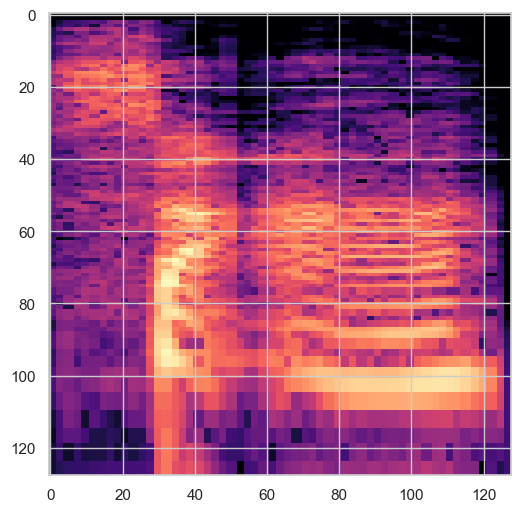

In [277]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(file_paths, tones_encoded, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Scale pixel values to the [0, 1] range
    rotation_range=150,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #horizontal_flip=True
)

def load_and_preprocess_image(file_path):
    img = tf.keras.preprocessing.image.load_img(file_path, target_size=(128, 128))
    img = tf.keras.preprocessing.image.img_to_array(img)
    #img = datagen.random_transform(img)
    img = img / 255.0
    return img

# Test with sample image
sample_image = load_and_preprocess_image(file_paths[0])
plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
#plt.axis('off')
plt.show()

In [278]:
# Load training images
X_train = np.array([load_and_preprocess_image(fp) for fp in X_train])
X_test = np.array([load_and_preprocess_image(fp) for fp in X_test])

X_train.shape()

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x28f0b7450>

In [ ]:
# Define model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Train model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
result = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

In [ ]:
model.save('tfModelTones')
# Print performance
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

In [ ]:
result.histroy

plt.title('Accuracy')
plt.plot(result.history['accuracy'], 'r')
plt.plot(result.history['val_accuracy'], 'b')
plt.show()

In [ ]:
# Predict for example file
example_image_file = 'spectrum_data/ao4_MV3.png'  
example_image = load_and_preprocess_image(example_image_file)
predictions = model.predict(np.expand_dims(example_image, axis=0))
print(f"Predictions: {predictions}")

# Get probabilities
label_probabilities = predictions[0]
class_names = [ '1', '2', '3', '4']  
label_probabilities_dict = {class_names[i]: label_probabilities[i] for i in range(len(class_names))}
predicted_class = label_encoder.inverse_transform([np.argmax(predictions)])[0]
print(f"Predicted Class: {predicted_class}")

# Print probabilities
for class_name, probability in label_probabilities_dict.items():
    print(f"Class: {class_name}, Probability: {probability:.4f}")


In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for test set
predicted_probabilities = model.predict(X_test)
true_labels = y_test

# Compute ROC curve and AUC for each class 
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(class_names)  
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [ ]:
audio_file = "../website/temp_audio.wav"
audio, sr = librosa.load(audio_file, sr=None)
info = get_mp3_info(audio,sr)
print("MP3 File Information:")
for key, value in info.items():
    print(f"{key}: {value}")

save_spectrum(audio=audio,output_file="test.png")
example_image = load_and_preprocess_image("test.png")
predictions = model.predict(np.expand_dims(example_image, axis=0))
highest_index = np.argmax(predictions)
print(f"Predictions: {predictions}")
print(f"The highest prediction is for tone: {highest_index+1}")

yt, index = librosa.effects.trim(audio, top_db=30, ref=np.max, frame_length=2048, hop_length=512)
info = get_mp3_info(yt,sr)
print("MP3 Trimmed File Information:")
for key, value in info.items():
    print(f"{key}: {value}")

save_spectrum(audio=yt,output_file="test2.png")
example_image = load_and_preprocess_image("test2.png")
predictions = model.predict(np.expand_dims(example_image, axis=0))
highest_index = np.argmax(predictions)
print(f"Predictions: {predictions}")
print(f"The highest prediction is for tone: {highest_index+1}")